# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

In [66]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [67]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [68]:
articles = df.groupby('email').count()['article_id']
articles.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

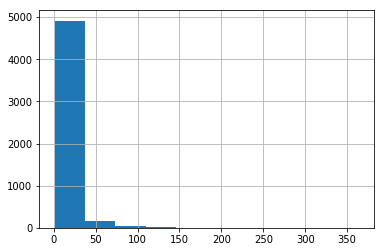

In [69]:
articles.hist();

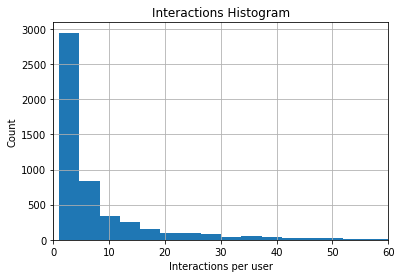

In [70]:
articles.hist(bins = 100);
plt.title('Interactions Histogram')
plt.xlabel('Interactions per user');
plt.ylabel('Count');
plt.xlim(0,60);

In [71]:
# Fill in the median and maximum number of user_article interactios below
articles.median()

3.0

In [72]:
articles.max()

364

In [73]:
median_val = articles.median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = articles.max() # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [74]:
df_content.nunique()# Find and explore duplicate articles

doc_body           1036
doc_description    1022
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64

In [76]:
df_content.shape

(1056, 5)

In [77]:
df_content.drop_duplicates(subset='article_id', inplace=True) # Remove any rows that have the same article_id - only keep the first

In [78]:
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [79]:
print(df.nunique())
print(df_content.count())
print(df.shape[0])

article_id     714
title          714
email         5148
dtype: int64
doc_body           1037
doc_description    1048
doc_full_name      1051
doc_status         1051
article_id         1051
dtype: int64
45993


In [80]:
df.nunique()[0]

714

In [81]:
df_content.article_id.nunique()

1051

In [83]:
df.email.nunique()

5148

In [84]:
df.shape[0]

45993

In [85]:
unique_articles = df.nunique()[0] # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique() # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [86]:
str(df.groupby('article_id').count().sort_values('email', ascending=False).head(1).index.values[0])

'1429.0'

In [87]:
most_viewed_article_id = df.groupby('article_id').count().sort_values('email', ascending=False).head(1).index.values[0] # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.groupby('article_id').count().sort_values('email', ascending=False).max()[0] # The most viewed article in the dataset was viewed how many times?

In [89]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [90]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': str(most_viewed_article_id),
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [92]:
df.groupby('title').count().sort_values('user_id', ascending=False).head().index.tolist()

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm']

In [93]:
df.groupby('article_id').count().sort_values('user_id', ascending=False).head().index.tolist()

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0]

In [94]:
df.groupby('article_id').count().sort_values('user_id', ascending=False).head(10)

,title,user_id
article_id,,
1429.0,937,937
1330.0,927,927
1431.0,671,671
1427.0,643,643
1364.0,627,627
1314.0,614,614
1293.0,572,572
1170.0,565,565
1162.0,512,512


In [95]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.groupby('title').count().sort_values('user_id', ascending=False).head(n).index.tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.groupby('article_id').count().sort_values('user_id', ascending=False).head(n).index.tolist()
    return top_articles # Return the top article ids

In [96]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [97]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [98]:
test_df = df.sample(100)

In [99]:
test_df.groupby(['user_id', 'article_id']).apply(lambda x:1).unstack().fillna(0)

article_id,20.0,43.0,92.0,109.0,125.0,131.0,134.0,151.0,164.0,173.0,...,1393.0,1394.0,1409.0,1410.0,1425.0,1427.0,1428.0,1429.0,1431.0,1436.0
user_id,,,,,,,,,,,,,,,,,,,,,
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    
    user_item = df.groupby(['user_id', 'article_id']).apply(lambda x:1).unstack().fillna(0)
    
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [101]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [102]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    simi = user_item.dot(user_item.loc[user_id])
    
    # sort by similarity
    sort_simi = simi.sort_values(ascending=False)
    
    # create list of just the ids
    most_similar_users = sort_simi.index.tolist()
    
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [103]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [129]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = list(df.loc[df['article_id'].isin(article_ids),'title'].unique())
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = user_item.loc[user_id]
    article_ids =  [str(article_id) for article_id in article_ids[article_ids == 1].index]
    article_names = get_article_names(article_ids)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    similar_users_id = find_similar_users(user_id)
    recs = []
    seen = get_user_articles(user_id)
    seen = set(seen[0])

    for user in similar_users_id:
        if len(recs) < m:
            ids = set(get_user_articles(user)[0])
            recommended_ids = ids.difference(seen)
            req_recs = m - len(recs)
            recommended_ids = list(recommended_ids)[:req_recs]
            recs.extend(recommended_ids)
            seen = seen.union(recommended_ids)
    
    return recs # return your recommendations for this user_id    

In [128]:
user_id = 1
m = 10
similar_users_id = find_similar_users(user_id)
recs = []
seen = get_user_articles(user_id)
seen = set(seen[0])

for user in similar_users_id:
    if len(recs) < m:
        ids = set(get_user_articles(user)[0])
        recommended_ids = ids.difference(seen)
        req_recs = m - len(recs)
        recommended_ids = list(recommended_ids)[:req_recs]
        recs.extend(recommended_ids)
        seen = seen.union(recommended_ids)

0
0
0
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

In [130]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['insights from new york car accident reports',
 'accelerate your workflow with dsx',
 'python machine learning: scikit-learn tutorial',
 'apache spark lab, part 2: querying data',
 'use decision optimization to schedule league games',
 'movie recommender system with spark machine learning',
 'spark 2.1 and job monitoring available in dsx',
 'ml algorithm != learning machine',
 'why even a moth’s brain is smarter than an ai',
 'from scikit-learn model to cloud with wml client']

In [131]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [150]:

simi = user_item.dot(user_item.loc[user_id])
df_simi = simi.sort_values(ascending=False).drop(user_id).to_frame("similarity").reset_index()

In [155]:
simi.sort_values(ascending=False)

user_id
1       36.0
3933    35.0
23      17.0
3782    17.0
203     15.0
4459    15.0
131     14.0
3870    14.0
46      13.0
4201    13.0
5041    12.0
49      12.0
3697    12.0
395     12.0
3910    11.0
322     11.0
3622    11.0
242     11.0
4642    10.0
290     10.0
2982    10.0
912     10.0
3540    10.0
98      10.0
754     10.0
3764    10.0
256      9.0
52       9.0
268      9.0
40       9.0
        ... 
2906     0.0
2909     0.0
2954     0.0
2910     0.0
2952     0.0
2951     0.0
2950     0.0
2947     0.0
2945     0.0
2944     0.0
2943     0.0
2942     0.0
2939     0.0
2938     0.0
2937     0.0
2936     0.0
2933     0.0
2931     0.0
2930     0.0
2929     0.0
2928     0.0
2927     0.0
2923     0.0
2922     0.0
2921     0.0
2920     0.0
2918     0.0
2916     0.0
2911     0.0
2575     0.0
Length: 5149, dtype: float64

In [153]:
df_simi.head()

,user_id,similarity
0,3933,35.0
1,23,17.0
2,3782,17.0
3,203,15.0
4,4459,15.0


In [156]:
interaction_count_df = df.user_id.value_counts().to_frame('interactions')

In [157]:
interaction_count_df

,interactions
23,364
3782,363
98,170
3764,169
203,160
4459,158
242,148
3910,147
49,147
131,145


In [159]:
neighbors_df = df_simi.merge(interaction_count_df, 
                                 left_on='user_id', 
                                 right_index=True).rename(columns={'user_id':'neighbor_id'})

In [160]:
neighbors_df

,neighbor_id,similarity,interactions
0,3933,35.0,45
1,23,17.0,364
2,3782,17.0,363
3,203,15.0,160
4,4459,15.0,158
5,131,14.0,145
6,3870,14.0,144
7,46,13.0,63
8,4201,13.0,61
9,5041,12.0,67


In [161]:
neighbors_df = neighbors_df.sort_values(['similarity', 
                                                'interactions'], 
                                            ascending=False)

In [162]:
neighbors_df

,neighbor_id,similarity,interactions
0,3933,35.0,45
1,23,17.0,364
2,3782,17.0,363
3,203,15.0,160
4,4459,15.0,158
5,131,14.0,145
6,3870,14.0,144
7,46,13.0,63
8,4201,13.0,61
10,49,12.0,147


In [167]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    simi = user_item.dot(user_item.loc[user_id])
    df_simi = simi.sort_values(ascending=False).drop(user_id).to_frame("similarity").reset_index()
    interaction_count_df = df.user_id.value_counts().to_frame('interactions')
    
    neighbors_df = df_simi.merge(interaction_count_df, 
                                 left_on='user_id', 
                                 right_index=True).rename(columns={'user_id':'neighbor_id'})
    
    neighbors_df = neighbors_df.sort_values(['similarity', 
                                                'interactions'], 
                                            ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    seen = get_user_articles(user_id)
    similar = get_top_sorted_users(user_id).neighbor_id
    rec = []
    
    for neighbor in similar:
        neighbor_read = get_user_articles(neighbor)
        new_recommend = np.setdiff1d(neighbor_read[0], seen[0], assume_unique=True)
        np.unique(rec.extend(new_recommend))
    
    recs = rec[:m]
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [168]:
seen = get_user_articles(user_id)
similar = get_top_sorted_users(user_id).neighbor_id
rec = []

for neighbor in similar:
    print(neighbor)
    neighbor_read = get_user_articles(neighbor)
    new_recommend = np.setdiff1d(neighbor_read[0], seen[0], assume_unique=True)
    np.unique(rec.extend(new_recommend))
    
recs = rec[:m]
rec_names = get_article_names(recs)

3933
23
3782
203
4459
131
3870
46
4201
49
3697
395
5041
242
3910
322
3622
98
3764
912
3540
290
2982
754
4642
21
4785
52
3596
204
371
5138
3784
273
135
4134
3621
40
4932
256
3637
621
3775
268
1355
3651
184
4892
249
3483
619
2926
696
186
3532
4293
765
4755
214
3141
64
3136
334
4038
488
4778
1897
58
3740
60
5140
288
4706
665
4484
38
3684
187
4934
125
67
3856
4774
72
4209
656
4206
3024
445
5079
3632
2790
54
5013
10
170
3169
295
3006
591
4277
3
8
2975
3353
223
3358
330
3197
195
3578
87
113
4883
3818
1059
4595
362
2981
379
3693
211
235
3485
807
409
1040
4404
3949
3794
28
4824
2161
324
4471
3408
111
69
90
689
3879
511
4933
263
3572
261
244
4543
733
2430
3354
4225
193
45
3500
750
3967
418
2903
88
4900
829
168
4901
4517
251
926
3829
304
4515
319
3005
4725
383
535
3898
4021
3801
670
1062
3741
3264
126
639
647
312
3172
22
4802
4526
4130
640
11
5023
4167
155
3966
4231
4792
65
3057
4088
63
3100
1163
24
1244
3535
641
280
215
4502
3376
4037
3441
4697
3118
3636
26
907
471
558
510
4453
82
1162
557
4082

1396
2607
3274
77
2403
1522
2412
1562
2337
2359
2364
1468
2425
1503
2445
1500
2452
3270
3655
4480
4286
3658
830
4043
382
389
4012
4473
4019
4018
4017
356
4094
3537
3602
364
4534
4064
3841
3834
3816
3820
466
4361
3809
476
654
675
423
678
4410
3785
4333
672
3962
4178
289
4228
549
578
284
964
4610
318
572
1043
4578
540
3517
3281
4585
4643
2914
1293
2891
4887
1373
1378
2721
2729
1375
2745
4930
2694
2821
2825
2801
2773
3161
4745
3145
1107
3175
1125
3144
3099
1100
4715
1075
3249
4738
1094
1089
3207
2988
4852
1243
3068
4780
4773
1635
1662
1649
2191
2210
2212
2127
1706
5063
2292
2302
5050
1573
1598
2264
1805
1990
1791
1882
1893
1920
1758
2058
2076
1774
2023
1569
2550
2553
2564
2568
1460
2572
2525
2631
2665
2619
2382
2402
2413
2372
1561
2339
1540
1547
5030
2473
1479
2502
1475
2464
2457
3667
3652
4036
4507
3630
3718
857
901
3549
348
3555
916
4253
3607
3609
4058
4054
4528
4529
3592
3934
4400
4398
690
4368
691
4350
461
3874
3748
4317
3963
947
3312
4205
1029
4675
4657
3440
529
956
1015
4185
4113
41

1141
704
1467
779
775
768
429
1428
1434
1053
1444
106
1448
1450
725
1514
451
708
84
1470
1471
435
1482
1484
1492
1495
1422
142
1339
1342
369
376
1351
848
1363
384
130
1366
368
1308
872
1326
1327
1328
366
367
1393
116
1402
1404
1420
1421
390
123
818
1388
1185
4065
4052
4046
4030
4069
4111
4084
4080
4078
4011
4007
3950
3948
3926
3923
3914
3964
3993
3990
3989
3984
3980
3965
4131
4261
4244
4226
4327
4320
4314
4309
4301
4292
4288
4224
4223
4162
4156
4138
4211
4182
3480
3597
3675
3660
3657
3656
3525
3512
3503
3496
3531
3568
3567
3545
3822
3845
3836
3810
3799
3900
3871
3869
3863
3735
3736
3789
3777
3766
3755
4888
4875
4906
4941
4937
4931
4928
4797
4789
4781
4779
4771
4767
4766
4764
4761
4804
4810
4808
4952
5088
5099
5094
4956
5072
5061
5142
5137
5132
5126
4990
4976
4962
4959
5039
5022
4476
4466
4464
4461
4455
4452
4443
4541
4536
4521
4499
4493
4387
4376
4374
4369
4391
4435
4434
4422
4395
4394
4544
4681
4677
4672
4649
4728
4721
4701
4592
4589
4575
4563
4558
4612
4609
4606
2330
2326
2319
2301
2

In [169]:
type(rec)

list

In [170]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['12.0', '109.0', '125.0', '142.0', '164.0', '205.0', '302.0', '336.0', '362.0', '465.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'dsx: hybrid mode', 'accelerate your workflow with dsx', 'learn tensorflow and deep learning together and now!', "a beginner's guide to variational methods", 'tensorflow quick tips', 'challenges in deep learning', 'neural networks for beginners: popular types and applications', 'statistics for hackers', 'introduction to neural networks, advantages and applications']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [171]:
### Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[0] # Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9]# Find the 10th most similar user to user 131

In [172]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

## Using Above Functions:

For new users, we will not have record of interaction so using the `get_top_articles_ids()` is an appropriate start. However, this may create issues in the recommendation as perhaps the users *true* interest is not in the top articles, but we designate their interest direction via the top recommendation.

## Using Other Ways for Recommendations:

Although not addressed in this notebook, a quick questionnaire of interests based upon content or category would give us some knowledge to help guide the recommendation process without creating bias of top articles. The questionnaire could provide its own table to be compared for similiarity, rather than interactions.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [36]:
df.groupby('article_id').count().sort_values('title', ascending=False).head(10)

,title,user_id
article_id,,
1429.0,937,937
1330.0,927,927
1431.0,671,671
1427.0,643,643
1364.0,627,627
1314.0,614,614
1293.0,572,572
1170.0,565,565
1162.0,512,512


In [37]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs_start = get_top_article_ids(10)
new_user_recs = []
for item in new_user_recs_start:
    
    new_user_recs.append(str(item))
print(new_user_recs)

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [38]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [39]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [40]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [41]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [42]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [43]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In [44]:
user_item_matrix.isnull().values.any()

False

In [45]:
user_item_matrix.isnull().sum().sum()

0

**Provide your response here.**
## FunkSVD vs. Numpy SVD

I believe that the difference between this project and the previously referenced lesson is the existence of null (Nan) values. Testing the currently referenced user_item_matrix with either `user_item_matrix.isnull().values.any()` or `user_item_matrix.isnull().sum().sum()` which produce a "False" or "0", indicating that there are no nan's. This would prevent SVD from being able to converge.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

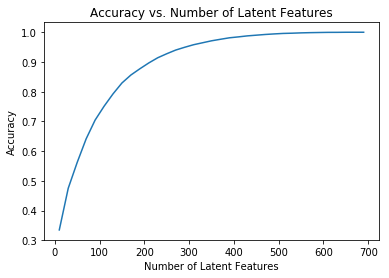

In [46]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [47]:
df.shape # just checking...

(45993, 3)

In [48]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [49]:
train_unique = len(df_train.article_id.unique())

test_unique = len(df_test.article_id.unique())

In [50]:
print(f'train_unique: {train_unique}')
print(f'test_unique: {test_unique}')

train_unique: 714
test_unique: 574


In [51]:
user_item_test_set = set(user_item_test.index)
user_item_train_set = set(user_item_train.index)
common_idx = list(user_item_train_set & user_item_test_set)

In [52]:
no_pred = len(list(user_item_test_set.difference(user_item_train_set)))
no_pred

662

In [53]:
pred = len(list(user_item_test_set.intersection(user_item_train_set)))
pred

20

In [54]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many movies can we make predictions for in the test set?': b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d, # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [55]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [56]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [57]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [58]:
train_common_idx = user_item_train.index.isin(test_idx)
train_common_col = user_item_train.columns.isin(test_arts)

In [59]:
u_test = u_train[train_common_idx, :]
vt_test = vt_train[:, train_common_col]

In [60]:
user_item_test_subset = user_item_test.loc[common_idx]

In [61]:
user_item_matrix.loc[common_idx, :].shape, user_item_est.shape

((20, 714), (5149, 714))

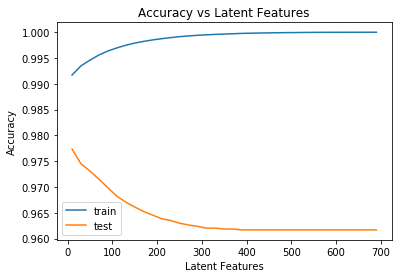

In [65]:
num_latent_feats_train = np.arange(10,700+10,20)

train_sum_errors = []
test_sum_errors = []

for k in num_latent_feats_train:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # dot product
    user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for prediction vs value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test_subset, user_item_test_est)
    
    # total errors
    train_errors = np.sum(np.sum(np.abs(diffs_train)))
    train_sum_errors.append(train_errors)
    
    test_errors = np.sum(np.sum(np.abs(diffs_test)))
    test_sum_errors.append(test_errors)
    
plt.plot(num_latent_feats_train, 1 - (np.array(train_sum_errors)/(user_item_train.shape[0]*user_item_train.shape[1])), label='train');
plt.plot(num_latent_feats_train, 1 - (np.array(test_sum_errors)/(user_item_test_subset.shape[0]*user_item_test_subset.shape[1])), label='test');
plt.legend(loc='best')
plt.xlabel('Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs Latent Features');
plt.show();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

In [69]:
user_item_train.shape[0]*user_item_train.shape[1]

3203718

In [76]:
for i, val in enumerate(num_latent_feats_train):
    print("*" * 20)
    print(i, " - latent features: ", val)
    print("train: ", 1 - np.array(train_sum_errors[i])/(user_item_train.shape[0]*user_item_train.shape[1]))
    print("test: ", 1 - np.array(test_sum_errors[i])/(user_item_test_subset.shape[0]*user_item_test_subset.shape[1]))

********************
0  - latent features:  10
train:  0.991715250843
test:  0.977351916376
********************
1  - latent features:  30
train:  0.993480699612
test:  0.974477351916
********************
2  - latent features:  50
train:  0.994596278449
test:  0.973083623693
********************
3  - latent features:  70
train:  0.995583568841
test:  0.971515679443
********************
4  - latent features:  90
train:  0.996366097141
test:  0.969860627178
********************
5  - latent features:  110
train:  0.996958221666
test:  0.968205574913
********************
6  - latent features:  130
train:  0.997481675978
test:  0.967073170732
********************
7  - latent features:  150
train:  0.997897755046
test:  0.966114982578
********************
8  - latent features:  170
train:  0.998227684209
test:  0.965243902439
********************
9  - latent features:  190
train:  0.998512041322
test:  0.964547038328
********************
10  - latent features:  210
train:  0.998746144324
tes

## Results

Using the figure or the output from the previous cell, the values seem to be related as the train and test sets increase/decrease in accuracy with the increase of latent features. The increase of latent features produces **overfitting** in the training whereas the test set accuracy *drops* until it levels out at ~96%. 

The datasets are small, and this constrains what can be accomplished with SVD. There are a very small amount of users shared between training and test sets. Additionally, the dataset is greatly affected by the imbalance which creates a high accuracy value. So, in this recommendation system, accuracy would be a misleading metric.

The current recommendation process needs to supplemented or augmented in some way to better address its "gap" areas in performance. 

Implementing a questionnaire to help generate a table akin to interactions could potentially help in the cold start problem. This may prove (in testing) a more positive and authentic response from users in their future interactions. Otherwise, some sort of combination of recommendation methods that is privisioned and utilized with ranking may prove effective in the instances of few interactions for newer users. Both of these approaches could be reinforced via a feedback questionnaire (even a 1-click user input). This would strengthen or penalize recommendations from other methods.

Necessary to any new development with the current recommendation model is a way to acutely measure and test the effectiveness and expediency between the previous model and a newly developed model. A/B Testing with careful constraints within the evaluation metric and validity to avoid biasing should be able to provide insight to true performance comparison.

A/B testing could be designed as:

- Cookie-based splitting to assign to groups (control/experiment)
    - User Interaction and Experience may differ in purpose - constrains should be implemented to help control the study
    - Assessing and possibly maintaining the randomness of the groups - should be tested
- Specific designing the evaluation metric to prove overall benefit and improvement
    - the easiest metric to perceive is the amount of users that are clicking on recommendations - this number should increase but there are be associated positive interactions or negative interactions. 
        - In example, user may click on recommendation and found the recommendation so unfavorable that they never returned again. if this happened in mass instances, the evaluation of "more clicks" would seem positive, but the overflow traffic would be lower.
- Validity of the improvement is related to and thus helps control the evaluation metric design
- Bias can be introduced in unpredictable ways -
    - it would be important to assure the size of the experiement participants (users) as well as assess an adequate duration/timeframe of testing

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [77]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0